In [14]:
import random
import os
import numpy as np
import torch

def seed_everything(seed=1):
    """
    """
    # 1. Python & Numpy
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
    # 2. PyTorch (CPU & GPU)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    print(f"🔒 Locked Random Seed: {seed}")

# --- GỌI HÀM ---
seed_everything(1)

🔒 Locked Random Seed: 1


In [15]:
#import
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import auc
from scipy.stats import kendalltau
from dragonnet import DragonNetBase, tarreg_loss, dragonnet_loss, EarlyStopper

In [16]:
#load data
df_men =pd.read_csv(r"C:\Users\Lenovo\Documents\Neu 2025-2026\Lab\Hillstrom-Men.csv")
df_men = df_men.drop(columns="Unnamed: 0")
print ("---------------------------")
print ("null count:")
print (df_men.isnull().sum())
print ("---------------------------")
print(df_men.dtypes)
print ("---------------------------")
print ("labels:")
print(df_men.columns.tolist())
print ("---------------------------")
print("data shape:")
print(df_men.shape)


---------------------------
null count:
recency            0
history_segment    0
history            0
mens               0
womens             0
zip_code           0
newbie             0
channel            0
visit              0
conversion         0
spend              0
treatment          0
dtype: int64
---------------------------
recency              int64
history_segment     object
history            float64
mens                 int64
womens               int64
zip_code            object
newbie               int64
channel             object
visit                int64
conversion           int64
spend              float64
treatment            int64
dtype: object
---------------------------
labels:
['recency', 'history_segment', 'history', 'mens', 'womens', 'zip_code', 'newbie', 'channel', 'visit', 'conversion', 'spend', 'treatment']
---------------------------
data shape:
(42613, 12)


In [17]:
#Hillstrom-men
#split num and cate
num_cols = df_men.select_dtypes(include=["float64", "int64"]).columns
cate_cols = ['zip_code', 'channel']
df_men["history_segment"] =df_men["history_segment"].map({
    "1) $0 - $100": '1', 
    "2) $100 - $200": 2, 
    "3) $200 - $350": "3",
    "4) $350 - $500": "4",
    "5) $500 - $750": "5",
    "6) $750 - $1,000": "6",
    "7) $1,000 +": "7"                         
})
#split x y t
y_men = df_men["spend"]
t_men = df_men["treatment"]
x_men = df_men.drop(columns=["spend", "treatment", "visit", "conversion"])

x_men_encode = pd.get_dummies(x_men, columns=cate_cols, drop_first=True)
#train test split
x_men_train, x_men_test_val,t_men_train, t_men_test_val, y_men_train, y_men_test_val = train_test_split(x_men_encode,t_men.values, y_men.values, test_size=0.4, random_state=42, stratify=t_men)
x_men_val, x_men_test, t_men_val, t_men_test, y_men_val, y_men_test = train_test_split(x_men_test_val, t_men_test_val, y_men_test_val, test_size= 0.75, random_state=42, stratify=t_men_test_val)

# #encode
# x_men_train_encode = pd.get_dummies(x_men_train, columns=cate_cols, drop_first=True)
# x_men_val_encode = pd.get_dummies(x_men_val, columns=cate_cols, drop_first=True)
# x_men_test_encode = pd.get_dummies(x_men_test, columns=cate_cols, drop_first=True)

#scale
scaler = StandardScaler()
x_men_train = scaler.fit_transform(x_men_train)
x_men_val = scaler.transform(x_men_val)
x_men_test = scaler.transform(x_men_test)

In [18]:
#Transform to tensor
def to_tensor(df):
    return torch.tensor(df, dtype=torch.float32)

x_men_train_t = to_tensor(x_men_train)
x_men_val_t = to_tensor(x_men_val)
x_men_test_t = to_tensor(x_men_test)

y_men_train_t = to_tensor(y_men_train).unsqueeze(1)
y_men_val_t = to_tensor(y_men_val).unsqueeze(1)
y_men_test_t = to_tensor(y_men_test).unsqueeze(1)

t_men_train_t = to_tensor(t_men_train.astype(float)).unsqueeze(1)
t_men_val_t = to_tensor(t_men_val.astype(float)).unsqueeze(1)
t_men_test_t = to_tensor(t_men_test.astype(float)).unsqueeze(1)

#Data loader
train_dataset = TensorDataset(x_men_train_t, t_men_train_t, y_men_train_t)
val_dataset = TensorDataset(x_men_val_t, t_men_val_t, y_men_val_t)
test_dataset = TensorDataset(x_men_test_t, t_men_test_t, y_men_test_t)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print ("-------------------------------------------------------------")
print ("✅Completed tranform to tensor✅")
print (f"Shape of train: x={x_men_train_t.shape}; y ={y_men_train_t.shape}; t={t_men_train_t.shape}")
print (f"Shape of val: x={x_men_val_t.shape}; y={y_men_val_t.shape}; t={t_men_val_t.shape}")
print (f"Shape of test: x={x_men_test_t.shape}; y={y_men_test_t.shape}; t={t_men_test_t.shape}")



-------------------------------------------------------------
✅Completed tranform to tensor✅
Shape of train: x=torch.Size([25567, 10]); y =torch.Size([25567, 1]); t=torch.Size([25567, 1])
Shape of val: x=torch.Size([4261, 10]); y=torch.Size([4261, 1]); t=torch.Size([4261, 1])
Shape of test: x=torch.Size([12785, 10]); y=torch.Size([12785, 1]); t=torch.Size([12785, 1])


Evaluation metrics

In [19]:
# --- HÀM UTILITY: Thực hiện tính toán Cumulative Gain ---
def _calculate_cumulative_curves(df, label_feature, treatment_feature):
    """Tính toán Uplift Curve và Qini Curve theo bucket (tích lũy)"""
    
    # 1. Các biến cơ bản
    bucket_diff = []
    res, population, rand_res = [], [], []
    bucket_ids = sorted(list(set(df['bucket'].values)))
    
    # 2. Random Baseline (Code tác giả dùng)
    # Tách nhóm Control/Treat và thêm nhiễu ngẫu nhiên
    l0, l1 = df.loc[df[treatment_feature[0]]==0], df.loc[df[treatment_feature[0]]==1]
    mean0, mean1 = l0[label_feature].values.mean(), l1[label_feature].values.mean()
    r0 = (np.random.rand(len(l0)) - 0.5)/100000 + mean0 # Random Mean Control
    r1 = (np.random.rand(len(l1)) - 0.5)/100000 + mean1 # Random Mean Treat
    df['random'] = list(r0) + list(r1) # Tác giả cần phải sort lại df sau khi thêm random, nhưng logic của họ là thêm vào list đã sort theo t (như dòng dưới)
    
    # Do hàm metrics của tác giả có các bước sort lại và thêm random rất phức tạp,
    # ta chỉ giữ lại logic tính cumuGain/cumu_random chính để đơn giản hóa.
    
    # --- Tính Cumulative Gain cho từng bucket ---
    for i in bucket_ids:
        # Lấy các bucket từ 0 đến i (tích lũy)
        dbucket = df.loc[df.bucket <= i]
        db_base = dbucket.loc[dbucket[treatment_feature[0]] == 0] # Control
        db_exp = dbucket.loc[dbucket[treatment_feature[0]] == 1] # Treatment
        
        len_base = len(db_base)
        len_exp = len(db_exp)

        if len_base == 0 or len_exp == 0:
            # Bỏ qua nếu không có mẫu trong nhóm (chỉ xảy ra nếu bucket_num quá lớn)
            continue
        
        # Công thức Tác giả cho AUUC (Cumulative Uplift: MeanDiff * TotalPop)
        cumuGain_AUUC = (db_exp[label_feature].mean() - db_base[label_feature].mean()) * (len_base + len_exp)
        
        # Công thức Tác giả cho AUQC (Qini Gain: Sum(T) - Sum(C) * (Nt/Nc))
        cumuGain_AUQC = db_exp[label_feature].sum() - db_base[label_feature].sum() * (len_exp / len_base)
        
        # Lấy giá trị AUUC (vì AUUC trong code tác giả dùng công thức tương tự Qini trong các bài khác)
        res.append(cumuGain_AUUC)
        population.append(len_base + len_exp)
        
        # Tính Random tương ứng
        cumu_random = db_exp['random'].sum() - db_base['random'].sum() * (len_exp / len_base)
        rand_res.append(cumu_random)

    # Tạo DataFrame kết quả
    cumuGain_df = pd.DataFrame({'cumuGain': res, 'population': population, 'random': rand_res})
    
    return cumuGain_df



def get_uplift_metrics(y_true, t_true, uplift_pred, k=0.3, bins=10, plot=True):
    """
    Tính toán Metrics theo đúng chuẩn file utils.py của tác giả.
    Tách biệt logic tính AUUC và AUQC.
    """
    
    # --- 1. CHUẨN BỊ DỮ LIỆU ---
    # Ép kiểu an toàn
    y_true = np.array(y_true).flatten()
    t_true = np.array(t_true).flatten()
    uplift_pred = np.array(uplift_pred).flatten()
    
    # Tạo DataFrame
    data = pd.DataFrame({'y': y_true, 't': t_true, 'pred': uplift_pred})
    
    # Sort theo điểm dự đoán giảm dần
    data = data.sort_values(by='pred', ascending=False)
    
    # Chia Bucket (qcut theo logic tác giả: -pred)
    try:
        data['bucket'] = pd.qcut(-data['pred'], bins, labels=False, duplicates='drop')
    except:
        data['bucket'] = pd.cut(-data['pred'], bins, labels=False) 

    # --- 2. TẠO RANDOM BASELINE (Theo utils.py) ---
    # Tác giả tạo feature 'random' bằng mean + nhiễu siêu nhỏ
    l0 = data.loc[data['t']==0]
    l1 = data.loc[data['t']==1]
    
    mean0 = l0['y'].mean()
    mean1 = l1['y'].mean()
    
    # Công thức nhiễu: (rand - 0.5)/100000 + mean
    r0 = (np.random.rand(len(l0)) - 0.5)/100000 + mean0
    r1 = (np.random.rand(len(l1)) - 0.5)/100000 + mean1
    
    data.loc[data['t']==0, 'random'] = r0
    data.loc[data['t']==1, 'random'] = r1
    
    # --- 3. HÀM TÍNH ĐƯỜNG CONG (Curve Calculator) ---
    def calculate_curve(metric_type):
        """
        metric_type: 'auuc' hoặc 'auqc'
        """
        res_list, pop_list, rand_res_list = [], [], []
        bucket_ids = sorted(data['bucket'].unique())
        
        for i in bucket_ids:
            # Lấy dữ liệu tích lũy
            dbucket = data.loc[data.bucket <= i]
            db_base = dbucket.loc[dbucket['t'] == 0] # Control
            db_exp = dbucket.loc[dbucket['t'] == 1]  # Treatment
            
            len_base = len(db_base)
            len_exp = len(db_exp)
            
            if len_base == 0 or len_exp == 0:
                continue
                
            # --- CÔNG THỨC KHÁC BIỆT ---
            if metric_type == 'auuc':
                # AUUC: Dùng Hiệu của Trung Bình * Tổng Dân Số
                # Formula: (Mean_T - Mean_C) * (N_T + N_C)
                val_gain = (db_exp['y'].mean() - db_base['y'].mean()) * (len_base + len_exp)
                rand_gain = (db_exp['random'].mean() - db_base['random'].mean()) * (len_base + len_exp)
            else: 
                # AUQC: Dùng Tổng T - Tổng C có scale
                # Formula: Sum_T - Sum_C * (N_T / N_C)
                val_gain = db_exp['y'].sum() - db_base['y'].sum() * (len_exp / len_base)
                rand_gain = db_exp['random'].sum() - db_base['random'].sum() * (len_exp / len_base)
            
            res_list.append(val_gain)
            rand_res_list.append(rand_gain)
            pop_list.append(len_base + len_exp)
            
        # Fix điểm cuối của Random bằng Model (ép buộc gặp nhau ở 100%)
        if len(res_list) > 0:
            rand_res_list[-1] = res_list[-1]
            
        return res_list, pop_list, rand_res_list

    # --- 4. TÍNH TOÁN & CHUẨN HÓA (Normalization) ---
    def normalize_and_score(res, pop, rand_res):
        if len(res) == 0: return 0.0, [], [], [], []
        
        # Gap0 là giá trị cuối cùng (Tổng Uplift toàn tập)
        gap0 = res[-1]
        
        # Chuẩn hóa chia cho abs(gap0) - Logic tác giả
        norm_factor = abs(gap0) if abs(gap0) > 1e-9 else 1.0
        
        y_norm = [x / norm_factor for x in res]
        y_rand_norm = [x / norm_factor for x in rand_res]
        
        # Trục hoành chuẩn hóa [0, 1]
        pop_max = max(pop)
        x_norm = [p / pop_max for p in pop]
        
        # Thêm điểm (0,0)
        y_final = np.append(0, y_norm)
        y_rand_final = np.append(0, y_rand_norm)
        x_final = np.append(0, x_norm)
        
        # Tính AUC bằng quy tắc hình thang (trapz)
        score = np.trapezoid(y_final, x_final)
        
        # Xử lý trường hợp gap0 âm (như trong code tác giả: if gap0 < 0 ...)
        # Tác giả cộng thêm diện tích hình vuông nếu gap < 0, 
        # nhưng ở đây ta cứ lấy raw score trước cho dễ so sánh.
        
        return score, x_final, y_final, y_rand_final

    # --- CHẠY TÍNH TOÁN ---
    # 1. AUUC
    res_u, pop_u, rand_u = calculate_curve('auuc')
    auuc_score, x_u, y_u, yr_u = normalize_and_score(res_u, pop_u, rand_u)
    
    # 2. AUQC
    res_q, pop_q, rand_q = calculate_curve('auqc')
    auqc_score, x_q, y_q, yr_q = normalize_and_score(res_q, pop_q, rand_q)

    # --- 5. TÍNH CÁC METRICS KHÁC ---
    # Lift@K
    h = k * len(set(data.bucket))
    dbucket = data.loc[data.bucket <= h]
    mean_t = dbucket.loc[dbucket['t']==1, 'y'].mean()
    mean_c = dbucket.loc[dbucket['t']==0, 'y'].mean()
    lift_val = mean_t - mean_c
    if np.isnan(lift_val): lift_val = 0.0
        
    # KRCC (Kendall Rank)
    bin_stats = data.groupby('bucket').apply(
        lambda x: x.loc[x['t']==1, 'y'].mean() - x.loc[x['t']==0, 'y'].mean()
    ).fillna(0)
    bin_preds = data.groupby('bucket')['pred'].mean().fillna(0)
    
    # argsort để lấy thứ hạng
    krcc, _ = kendalltau(np.argsort(bin_preds.values), np.argsort(bin_stats.values))
    if np.isnan(krcc): krcc = 0.0

    # --- 6. VẼ BIỂU ĐỒ (Dual Plot) ---
    if plot:
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        # Plot AUQC (Qini)
        axes[0].plot(x_q, y_q, marker='.', label=f'Model (AUQC={auqc_score:.4f})', color='navy')
        axes[0].plot(x_q, yr_q, marker='.', label='Random', color='gray', linestyle='--')
        axes[0].set_title('Qini Curve (AUQC)', fontsize=14)
        axes[0].set_xlabel('Fraction targeted')
        axes[0].set_ylabel('Normalized Value')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # Plot AUUC (Uplift)
        axes[1].plot(x_u, y_u, marker='.', label=f'Model (AUUC={auuc_score:.4f})', color='darkgreen')
        axes[1].plot(x_u, yr_u, marker='.', label='Random', color='gray', linestyle='--')
        axes[1].set_title('Uplift Curve (AUUC)', fontsize=14)
        axes[1].set_xlabel('Fraction targeted')
        axes[1].set_ylabel('Normalized Value')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

    return {
        "AUQC": auqc_score,
        "AUUC": auuc_score,
        "Lift": lift_val,
        "KRCC": krcc
    }

Build Model

In [20]:
class DragonNetWrapper:
    def __init__(self, input_dim, epochs=50, lr = 0.001, alpha =1.0, beta =1.0):
        self.model = DragonNetBase(input_dim)
        self.epochs = epochs
        self.optim = torch.optim.Adam(self.model.parameters(), lr=lr)
        self.alpha = alpha
        self.beta = beta
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)
        self.early_stopper = EarlyStopper(patience=10, min_delta=0.001)
        
    def fit (self, train_loader, val_loader):
        print (f"Begin training Dragonnet Baseline🔃🔃🔃 ") 
        early_stopper = EarlyStopper(patience=10, min_delta=0.001)
        for epoch in range(self.epochs):
            self.model.train()
            epoch_loss=0
            for x_batch , t_batch ,y_batch in train_loader:
                x_batch = x_batch.to(self.device)
                
                t_batch =t_batch.to(self.device) 
                y_batch = y_batch.to(self.device)
                
                self.optim.zero_grad()
                
                y0_pred, y1_pred, t_pred, eps = self.model(x_batch)
                
                loss = tarreg_loss(y_batch, t_batch, t_pred, y0_pred, y1_pred, eps, self.alpha, self.beta )
                
                loss.backward()
                self.optim.step()
                epoch_loss += loss.item()
            
            val_loss = self.validate(val_loader)
            
            if (epoch+1) % 5 == 0:
                print(f"Epoch {epoch+1} | Train Loss: {epoch_loss/len(train_loader):.4f} | VAL LOSS: {val_loss:.4f}")
            if self.early_stopper.early_stop(val_loss):
                print(f"⏹️ Dừng sớm tại epoch {epoch+1} vì Val Loss không giảm nữa.")
                break
    def validate(self, val_loader):
        self.model.eval()
        val_loss = 0
        with torch.no_grad():
            for X, t, y in val_loader:
                X, t, y = X.to(self.device), t.to(self.device), y.to(self.device)
                y0, y1, t_p, eps = self.model(X)
                val_loss += tarreg_loss(y, t, t_p, y0, y1, eps, self.alpha, self.beta).item()
        return val_loss / len(val_loader)
                
    def predict(self, x):
        self.model.eval()
        with torch.no_grad():
            y0, y1, t_p, _  = self.model(x.to(self.device))
        return y0.cpu(), y1.cpu(), t_p.cpu()

In [21]:
dragonnet = DragonNetWrapper(input_dim=x_men_train_t.shape[1], epochs=50, alpha = 1.0, beta =1.0, lr=0.001)
dragonnet.fit(train_loader, val_loader)

print ("Complete training")

Begin training Dragonnet Baseline🔃🔃🔃 
Epoch 5 | Train Loss: 28193.1197 | VAL LOSS: 50310.5959
Epoch 10 | Train Loss: 28155.0335 | VAL LOSS: 50319.7583
⏹️ Dừng sớm tại epoch 13 vì Val Loss không giảm nữa.
Complete training


Evaluating baseline🔃🔃🔃


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_9072\1805000247.py:187: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  bin_stats = data.groupby('bucket').apply(


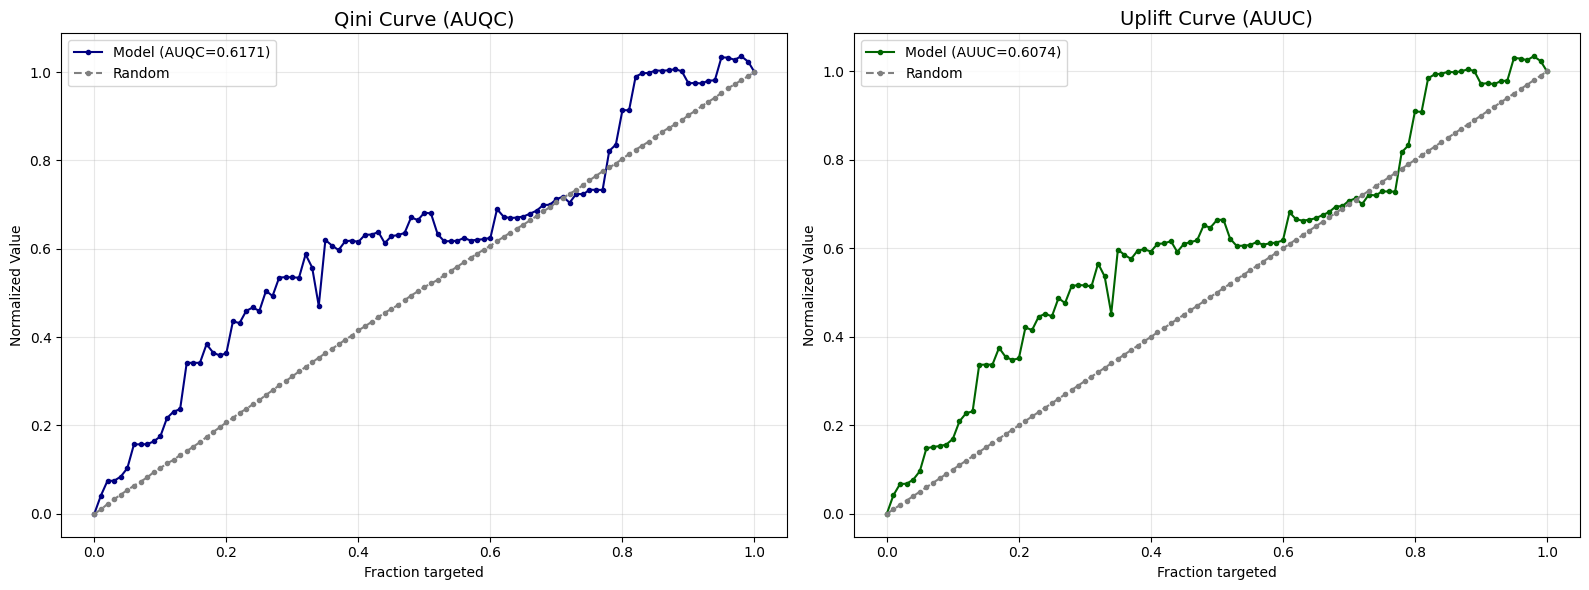

----------------------------------------
 Evaluation 
AUUC: 0.60744
Lift30: 1.3234
KRCC: 0.0881
AUQC: 0.61709
----------------------------------------


In [25]:
print ("Evaluating baseline🔃🔃🔃")
y0_pred, y1_pred, _ = dragonnet.predict(x_men_test_t)

uplift_pred = (y1_pred - y0_pred).numpy().flatten()

y_true = y_men_test_t.numpy().flatten()
t_true = t_men_test_t.numpy().flatten()
metrics = get_uplift_metrics(y_true, t_true, uplift_pred, k=0.3, bins=100)


print("-" * 40)
print(f" Evaluation ")
print(f"AUUC: {metrics['AUUC']:.5f}")
print(f"Lift30: {metrics['Lift']:.4f}")
print(f"KRCC: {metrics['KRCC']:.4f}")
print(f"AUQC: {metrics['AUQC']:.5f}")
print("-" * 40)